In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pickle_cache import PickleCache 
from autoplan.trainer import ClassEvaluation
import numpy as np
import json
from grammars.rainfall.labels import CountWhere, GeneralRainfallLabels as Labels
from scripts.rainfall_ingest import ingest_dataset
pcache = PickleCache()

In [3]:
(X, Y) = pcache.get('xy')

In [4]:
Xemb = pcache.get('known_embs')

In [5]:
Xparse = pcache.get('xparse')

In [15]:
(Xord, _) = pcache.get('xordy')

In [32]:
Xparse[0]

{'START': [0, None],
 'recursion': [1, 'rec'],
 '_type': [1, 'float'],
 'uses_annotation': [0, True],
 'helper_in_body': [0, True],
 'raises_failwith': [0, True],
 'fail_message': [0, '"No rain was collected"'],
 'strategy': [0, 2],
 'rainfall_body_specs': [1, 'recurse'],
 'recursion_strategy': [1, 'let'],
 'check_empty_list': [0, '[]'],
 'check_div_by_zero': [0, True],
 'gt_zero': [0, True],
 'separate_sentinel_check': [0, True],
 'recurse_empty_list': [1, False],
 'check_positive_head': [0, True]}

In [45]:
def heuristic_clf(X):
    strat = Labels(X['strategy'][1])
    if strat == Labels.CleanFirst:
        return CountWhere.Rainfall if X['helper_in_body'][1] or X['average_strategy'][1] != 'direct' \
                else CountWhere.Helper
    elif strat == Labels.CleanInSC:
        return CountWhere.Rainfall if X['anonymous_helpers'][1] else CountWhere.Own
    elif strat == Labels.SingleLoop:
        return CountWhere.Helper

In [46]:
from sklearn.metrics import accuracy_score
accuracy_score(Y, [int(heuristic_clf(X)) for X in Xparse])

0.8222222222222222

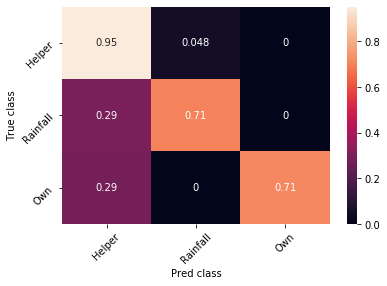

In [47]:
evl = ClassEvaluation.from_preds(
    Y, [int(heuristic_clf(X)) for X in Xparse], ['Helper', 'Rainfall', 'Own'])
evl.plot_cm()

In [52]:
Xparse[37]

{'START': [0, None],
 'recursion': [1, 'rec'],
 '_type': [0, 'int'],
 'uses_annotation': [0, True],
 'helper_in_body': [1, False],
 'raises_failwith': [1, False],
 'fail_message': [0, '"No rain was collected"'],
 'strategy': [1, 0],
 'average_strategy': [0, 'direct'],
 'main_strategy': [0, 'match'],
 'check_empty_list': [0, '[]'],
 'return_empty_list': [0, True]}

In [51]:
evl.print_incorrect(ingest_dataset('T1'), label_set=list(CountWhere))

Skipped 16 programs
Program 18:
let rainfall (aloi : int list) =
  (let rec rf_helper (aloi : int list) =
     (match aloi with
      | [] -> []
      | (-999)::_ -> []
      | hd::tl -> hd :: (rf_helper tl) : int list) in
   let rf_list = List.filter (fun x -> x >= 0) (rf_helper aloi) in
   (List.fold_right (+) rf_list 0) / (List.length rf_list) : int)

Pred: CountWhere.Helper
True: CountWhere.Rainfall

Program 19:
let rec stop (aloi : int list) =
  (match aloi with
   | [] -> []
   | hd::tl -> if hd = (-999) then [] else hd :: (stop tl) : int list)
let rec non_negative_average (aloi : int list) =
  (let average (alon : int list) =
     (match alon with
      | [] -> 0.0
      | _::_ ->
          (float_of_int (List.fold_right (+) alon 0)) /.
            (float_of_int (List.length alon)) : float) in
   average (List.filter (fun x -> x >= 0) aloi) : float)
let rec rainfall (aloi : int list) =
  (match aloi with | [] -> 0.0 | hd::tl -> non_negative_average (stop aloi) : 
  float)

Pred:

In [11]:
X = np.array(X)
Y = np.array(Y)

In [20]:
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

models = {
    'svm': svm.SVC(gamma='scale'),
    'tree': tree.DecisionTreeClassifier(random_state=1),
    'mlp': MLPClassifier(max_iter=1000),
    'lr': LogisticRegression(multi_class='auto')
}

{
    k: np.mean(cross_val_score(clf, Xord, Y, cv=7))
    for k, clf in models.items()
}

/home/wcrichto/autoplan/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wcrichto/autoplan/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wcrichto/autoplan/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wcrichto/autoplan/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/wcrichto/autoplan/.env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default so

{'svm': 0.857142857142857,
 'tree': 0.7108843537414965,
 'mlp': 0.7959183673469388,
 'lr': 0.857142857142857}